# Simulation


## 1. Simulate data according to the proposed model.

In [199]:
%pip install numpy matplotlib scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [200]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)

In [201]:
# Defining eta function (could be linear, quasratic, constant, sinus, etc)

def eta_linear_bis(x: np.ndarray, eta_max) -> np.ndarray:
    """Linear noise: η(x) = η_max * (eta_max + 0.4*(x+1)/2)"""
    x_flat = x if x.ndim == 1 else np.mean(x, axis=1)
    return eta_max * (eta_max +  (np.abs(x_flat))/20)

def eta_linear(x: np.ndarray, eta_max) -> np.ndarray:
    """Linear noise: η(x) = η_max * (eta_max + 0.4*(x+1)/2)"""
    x_flat = x if x.ndim == 1 else np.mean(x, axis=1)
    return eta_max * (eta_max + 0.4 * (x_flat + 1) / 2)

def eta_constant(X,eta_max):
    return np.array([eta_max for i in range(X.shape[0])])

In [202]:
# Generate data
def generate_data(m: int, d: int, eta_func, eta_max):
    # Generate X uniformly in [-1, 1]^d
    X = np.random.uniform(-1, 1, size=(m, d))
    
    # Generate true labels Y uniformly from {-1, +1}
    Y = np.array([1 for n in range(m)], dtype=int)
    # Y = np.random.choice([-1, 1], size=m)


    # Compute true noise levels
    eta_true = eta_func(X, eta_max)
    
    # Generate corrupted labels Z
    Z = np.zeros(m,  dtype=np.int_)
    for i in range(m):
        # Flip label with probability η(X_i)
        if np.random.rand() < eta_true[i]:
            Z[i] = -Y[i]  # Flip
        else:
            Z[i] = Y[i]   # Keep
    
    return X, Y, Z, eta_true

In [203]:
# Test
eta_max=0.5
N = 10
m = 500
d = 1
X, Y, Z, eta_true = generate_data(m, d, eta_constant, eta_max=0.1)

print(f"Generated {m} samples in dimension d={d}")
print(f"X shape: {X.shape}")
print(f"Y values: {np.unique(Y)} (counts: {np.bincount((Y+1)//2)})")
print(f"Z values: {np.unique(Z)} (counts: {np.bincount((Z+1)//2)})")
print(f"Empirical flip rate: {np.mean(Y != Z):.3f}")
print(f"True average η: {np.mean(eta_true):.3f}")


Generated 500 samples in dimension d=1
X shape: (500, 1)
Y values: [1] (counts: [  0 500])
Z values: [-1  1] (counts: [ 43 457])
Empirical flip rate: 0.086
True average η: 0.100


## 2. Implement the estimator of η that you proposed.

In [204]:
def gaussian_kernel (u,d,h):
    """Has to be symmetrical"""
    factor = (2*np.pi)**(-d/2)
    return(factor * np.exp(-np.dot(u,u)/2))


In [205]:
def eta_estimator(X,Z,x,h):
    eta_tilde = 0
    denominator = 0
    d = X.shape[1]
    for i in range(len(X)):
        K = gaussian_kernel((X[i]-x)/h,d,h)
        eta_tilde += (1-Z[i])*K
        denominator += K

    eta_tilde = eta_tilde/(2*denominator)
    return(eta_tilde)


In [206]:
# # # Cross-validation to chose h

def cross_validation(eta,X,Z,h):
    error = 0

    for i in range(X.shape[0]):
            cross_X = np.delete(X,i,0)
            cross_Z = np.delete(Z,i,0)
            error+= (eta[i] - eta_estimator(cross_X,cross_Z,X[i],h))**2
    
    return((1/X.shape[0])*error)

# hs = np.linspace(1, 2, 30)
# errs = [cross_validation(eta_true,X, Z, h) for h in hs]

# plt.plot(hs, errs)
# plt.xlabel("h")
# plt.ylabel("CV error")

    

In [ ]:
def h_optimal(X,Z,eta_true,a,b,nbr_pas):
    optimal_h = 0
    min_error = np.inf
    for h in  np.linspace(a,b,nbr_pas):
        error = cross_validation(eta_true,X,Z,h)
        if error < min_error :
                optimal_h = h
                min_error = error
    return(optimal_h)


print(h_optimal(X,Z,eta_true,0.1,1.5,15))

[0.  0.1 0.2 0.3 0.4 0.5]
1.5


In [ ]:
X_test, Y_test, Z_test, eta_true = generate_data(30,d,eta_linear,eta_max=0.5)
estimated_eta = []
for x in X_test :
    estimated_eta.append(eta_estimator(X,Z,x,0.53))

print(f"Estimated value of eta {estimated_eta}")
print(f"Real value of eta : {eta_true}")

Estimated value of eta [0.08454448632683786, 0.08873260614210646, 0.08624430215721675, 0.08927599924334467, 0.08798232550538611, 0.08972253436943443, 0.08962712825564995, 0.08691890027338765, 0.08438046947883397, 0.08779794162584718, 0.08438527445986291, 0.08242361712125948, 0.08395950925600815, 0.08656067343759792, 0.08953864803822363, 0.08459565215085728, 0.08457621590515577, 0.08910847352742489, 0.08491776947459105, 0.08666560247630606, 0.08959630474821509, 0.08461754900724766, 0.0846240045817725, 0.08301704424191717, 0.08395240150185587, 0.08749941877045106, 0.08656056856354971, 0.087044462245896, 0.08482446206412389, 0.08745024102652833]
Real value of eta : [0.28702659 0.35838019 0.42458917 0.39644498 0.41131223 0.38175667
 0.38845531 0.41983913 0.2999336  0.34788499 0.29424189 0.4475336
 0.43881187 0.25788536 0.39111503 0.43504966 0.28611507 0.36358905
 0.43309766 0.2567892  0.38948405 0.3094698  0.43487924 0.44421165
 0.4388533  0.34484284 0.42240853 0.41890988 0.31382009 0.4157

## 3. Illustrate empirically its performance (estimation error, influence of the sample size m, the dimension d, and the noise level).

In [ ]:
result_estimator = np.array(estimated_eta)

In [ ]:
#Estimation error

def MSE(eta,eta_hat):
    error = 0
    error = (eta - eta_hat)**2
    
    return(np.mean(error))

print(MSE(eta_true,result_estimator))

0.08693672904585449


Text(0, 0.5, 'm')

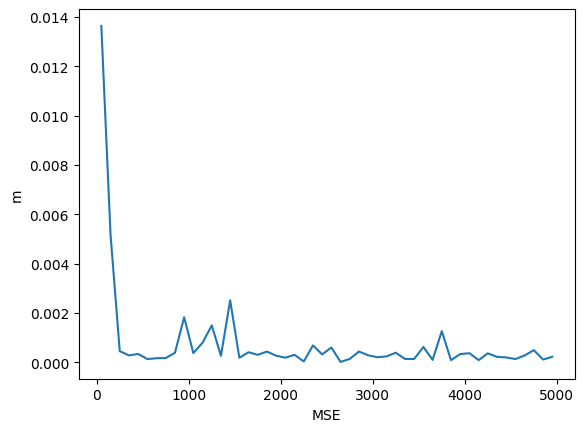

In [ ]:
#Influence of the sample size m
m_values=np.array([50 + i*100 for i in range(50)])
data_generation_values=[generate_data(m, d, eta_linear, eta_max) for m in m_values]
X_test, Y_test, Z_test, eta_true = generate_data(30,d,eta_linear,eta_max=0.5)
data_points = []
for data in data_generation_values:
    data_estimation_values = [eta_estimator(data[0],data[2],x,0.43) for x in X_test]
    data_points.append(MSE(eta_true,data_estimation_values))


plt.plot(m_values, data_points)
plt.xlabel("MSE")
plt.ylabel("m")


Text(0, 0.5, 'MSE')

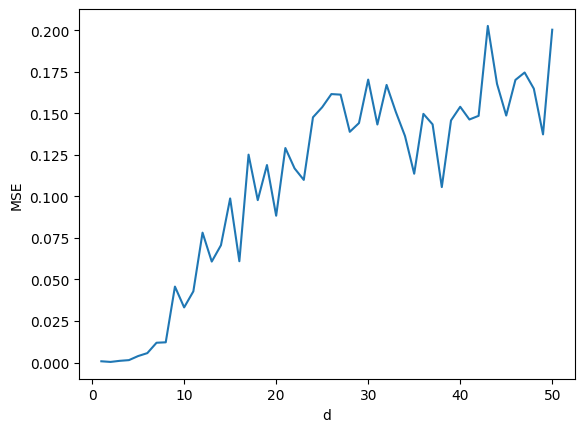

In [ ]:
#Influence of the sample size d
N = 50
d_values=np.array([1 + i for i in range(50)])
m = 1000
data_generation_values=[generate_data(m, d, eta_linear, eta_max) for d in d_values]
data_test = [generate_data(30, d, eta_linear, eta_max) for d in d_values]
data_points = []
for n in range(N):
    data = data_generation_values[n]
    X_test = data_test[n][0]
    eta_true = data_test[n][3]
    data_estimation_values = [eta_estimator(data[0],data[2],x,0.43) for x in X_test]
    data_points.append(MSE(eta_true,data_estimation_values))


plt.plot(d_values, data_points)
plt.xlabel("d")
plt.ylabel("MSE")

In [212]:
#Influence of noise level
N=6
eta_values = np.round(np.linspace(0, 0.5, N), 1)
print(eta_values)
m = 500
d=1
data_generation_values=[generate_data(m, d, eta_constant, 0.1) for eta_max in eta_values]
data_test = [generate_data(30, d, eta_constant, eta_max) for eta_max in eta_values]
data_points = []
for n in range(N):
    data = data_generation_values[n]
    X_test = data_test[n][0]
    eta_true_test = data_test[n][3]
    h = h_optimal(data[0],data[2],data[3],0.1,1.5,30)
    print(h)
    data_estimation_values = [eta_estimator(data[0],data[2],x,h) for x in X_test]
    data_points.append(MSE(eta_true_test,data_estimation_values))


plt.plot(eta_values, data_points)
plt.xlabel("d")
plt.ylabel("MSE")



[0.  0.1 0.2 0.3 0.4 0.5]
1.5


KeyboardInterrupt: 